In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

In [2]:
sleep_df = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv")
sleep_df.head(10)

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
2,3,Male,28,Doctor,6.2,6,60,8,Normal,125/80,75,10000,NaN
3,4,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
4,5,Male,28,Sales Representative,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
5,6,Male,28,Software Engineer,5.9,4,30,8,Obese,140/90,85,3000,Insomnia
6,7,Male,29,Teacher,6.3,6,40,7,Obese,140/90,82,3500,Insomnia
7,8,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,NaN
8,9,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,NaN
9,10,Male,29,Doctor,7.8,7,75,6,Normal,120/80,70,8000,NaN


In [3]:
# Check for NaN values
sleep_df.isna().sum()

Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             219
dtype: int64

### The 'Person ID' column can be dropped since it doesn't offer any relevant information for our model. Moreover, the 'Occupation' column also isn't relevant because the affects of one's occupation would already be accounted for in the 'Quality of Sleep' and 'Stress Level' columns. Therefore, we drop both of these columns.

In [5]:
sleep_df.drop('Person ID',axis=1, inplace=True)

In [6]:
sleep_df.drop('Occupation', axis=1, inplace=True)

In [7]:
# Check for duplicates
sleep_df.duplicated().sum()

244

### We observe that, aside from the Person ID, most of the entries are duplicates. Therefore, we drop these so that they don't introduce bias into our model.

In [9]:
sleep_df = sleep_df.drop_duplicates()

In [10]:
sleep_df.reset_index(inplace=True)

In [11]:
sleep_df = sleep_df.drop('index',axis=1)

### Note that the NaN values in the Sleep Disorder column refer to persons who do not have sleep disorder.

In [13]:
sleep_df = sleep_df.replace({np.nan: "No_Sleep_Disorder"})
sleep_df

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,Male,27,6.1,6,42,6,Overweight,126/83,77,4200,No_Sleep_Disorder
1,Male,28,6.2,6,60,8,Normal,125/80,75,10000,No_Sleep_Disorder
2,Male,28,5.9,4,30,8,Obese,140/90,85,3000,Sleep Apnea
3,Male,28,5.9,4,30,8,Obese,140/90,85,3000,Insomnia
4,Male,29,6.3,6,40,7,Obese,140/90,82,3500,Insomnia
...,...,...,...,...,...,...,...,...,...,...,...
125,Female,59,8.0,9,75,3,Overweight,140/95,68,7000,No_Sleep_Disorder
126,Female,59,8.1,9,75,3,Overweight,140/95,68,7000,No_Sleep_Disorder
127,Female,59,8.2,9,75,3,Overweight,140/95,68,7000,Sleep Apnea
128,Female,59,8.0,9,75,3,Overweight,140/95,68,7000,Sleep Apnea


### We categorize the blood pressure labels according to the guidelines provided in this article: https://www.mayoclinic.org/diseases-conditions/high-blood-pressure/in-depth/blood-pressure/art-20050982

In [14]:
sleep_df['Blood Pressure'].unique()

array(['126/83', '125/80', '140/90', '120/80', '132/87', '130/86',
       '117/76', '118/76', '128/85', '131/86', '128/84', '115/75',
       '135/88', '129/84', '130/85', '115/78', '119/77', '121/79',
       '125/82', '135/90', '122/80', '142/92', '140/95', '139/91',
       '118/75'], dtype=object)

In [15]:
Normal_Blood_P=['118/75', '115/75', '115/78', '118/76', '119/77', '117/76']
Elevated_Blood_P=['121/79']
S1_Hyper=['132/87', '125/82', '130/85', '130/86', '120/80', '125/80', '128/85', '135/88', '126/83', '135/90', '122/80', '128/84', '129/84','131/86']
S2_Hyper=['142/92', '140/90', '139/91', '140/95']

In [16]:
replace_dict = {value: 'Normal_Blood_Pressure' for value in Normal_Blood_P}
replace_dict2 = {value: 'Elevated_Blood_Pressure' for value in Elevated_Blood_P}
replace_dict3 = {value: 'Stage_1_Hypertension' for value in S1_Hyper}
replace_dict4 = {value: 'Stage_2_Hypertension' for value in S2_Hyper}
# Replace values in the 'Blood Pressure' column
sleep_df.loc[:, 'Blood Pressure'] = sleep_df['Blood Pressure'].replace(replace_dict)
sleep_df.loc[:, 'Blood Pressure'] = sleep_df['Blood Pressure'].replace(replace_dict2)
sleep_df.loc[:, 'Blood Pressure'] = sleep_df['Blood Pressure'].replace(replace_dict3)
sleep_df.loc[:, 'Blood Pressure'] = sleep_df['Blood Pressure'].replace(replace_dict4)
sleep_df.head(50)

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,Male,27,6.1,6,42,6,Overweight,Stage_1_Hypertension,77,4200,No_Sleep_Disorder
1,Male,28,6.2,6,60,8,Normal,Stage_1_Hypertension,75,10000,No_Sleep_Disorder
2,Male,28,5.9,4,30,8,Obese,Stage_2_Hypertension,85,3000,Sleep Apnea
3,Male,28,5.9,4,30,8,Obese,Stage_2_Hypertension,85,3000,Insomnia
4,Male,29,6.3,6,40,7,Obese,Stage_2_Hypertension,82,3500,Insomnia
5,Male,29,7.8,7,75,6,Normal,Stage_1_Hypertension,70,8000,No_Sleep_Disorder
6,Male,29,6.1,6,30,8,Normal,Stage_1_Hypertension,70,8000,No_Sleep_Disorder
7,Male,29,6.0,6,30,8,Normal,Stage_1_Hypertension,70,8000,No_Sleep_Disorder
8,Female,29,6.5,5,40,7,Normal Weight,Stage_1_Hypertension,80,4000,Sleep Apnea
9,Male,29,6.0,6,30,8,Normal,Stage_1_Hypertension,70,8000,Sleep Apnea


In [17]:
enc = preprocessing.OneHotEncoder()
enc.fit(sleep_df[['Blood Pressure']])
enc.categories_

[array(['Elevated_Blood_Pressure', 'Normal_Blood_Pressure',
        'Stage_1_Hypertension', 'Stage_2_Hypertension'], dtype=object)]

In [18]:
one_hot = enc.transform(sleep_df[['Blood Pressure']]).toarray()

In [19]:
sleep_df[['Elevated_Blood_Pressure', 'Normal_Blood_Pressure',
        'Stage_1_Hypertension', 'Stage_2_Hypertension']] = one_hot

In [20]:
sleep_df

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder,Elevated_Blood_Pressure,Normal_Blood_Pressure,Stage_1_Hypertension,Stage_2_Hypertension
0,Male,27,6.1,6,42,6,Overweight,Stage_1_Hypertension,77,4200,No_Sleep_Disorder,0.0,0.0,1.0,0.0
1,Male,28,6.2,6,60,8,Normal,Stage_1_Hypertension,75,10000,No_Sleep_Disorder,0.0,0.0,1.0,0.0
2,Male,28,5.9,4,30,8,Obese,Stage_2_Hypertension,85,3000,Sleep Apnea,0.0,0.0,0.0,1.0
3,Male,28,5.9,4,30,8,Obese,Stage_2_Hypertension,85,3000,Insomnia,0.0,0.0,0.0,1.0
4,Male,29,6.3,6,40,7,Obese,Stage_2_Hypertension,82,3500,Insomnia,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,Female,59,8.0,9,75,3,Overweight,Stage_2_Hypertension,68,7000,No_Sleep_Disorder,0.0,0.0,0.0,1.0
126,Female,59,8.1,9,75,3,Overweight,Stage_2_Hypertension,68,7000,No_Sleep_Disorder,0.0,0.0,0.0,1.0
127,Female,59,8.2,9,75,3,Overweight,Stage_2_Hypertension,68,7000,Sleep Apnea,0.0,0.0,0.0,1.0
128,Female,59,8.0,9,75,3,Overweight,Stage_2_Hypertension,68,7000,Sleep Apnea,0.0,0.0,0.0,1.0


### The One Hot Encoder worked as intended, so we drop the 'Blood Pressure' column.

In [22]:
sleep_df.drop('Blood Pressure', axis=1)

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Elevated_Blood_Pressure,Normal_Blood_Pressure,Stage_1_Hypertension,Stage_2_Hypertension
0,Male,27,6.1,6,42,6,Overweight,77,4200,No_Sleep_Disorder,0.0,0.0,1.0,0.0
1,Male,28,6.2,6,60,8,Normal,75,10000,No_Sleep_Disorder,0.0,0.0,1.0,0.0
2,Male,28,5.9,4,30,8,Obese,85,3000,Sleep Apnea,0.0,0.0,0.0,1.0
3,Male,28,5.9,4,30,8,Obese,85,3000,Insomnia,0.0,0.0,0.0,1.0
4,Male,29,6.3,6,40,7,Obese,82,3500,Insomnia,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,Female,59,8.0,9,75,3,Overweight,68,7000,No_Sleep_Disorder,0.0,0.0,0.0,1.0
126,Female,59,8.1,9,75,3,Overweight,68,7000,No_Sleep_Disorder,0.0,0.0,0.0,1.0
127,Female,59,8.2,9,75,3,Overweight,68,7000,Sleep Apnea,0.0,0.0,0.0,1.0
128,Female,59,8.0,9,75,3,Overweight,68,7000,Sleep Apnea,0.0,0.0,0.0,1.0


In [23]:
sleep_df.drop('Blood Pressure', axis=1, inplace=True)
sleep_df

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Elevated_Blood_Pressure,Normal_Blood_Pressure,Stage_1_Hypertension,Stage_2_Hypertension
0,Male,27,6.1,6,42,6,Overweight,77,4200,No_Sleep_Disorder,0.0,0.0,1.0,0.0
1,Male,28,6.2,6,60,8,Normal,75,10000,No_Sleep_Disorder,0.0,0.0,1.0,0.0
2,Male,28,5.9,4,30,8,Obese,85,3000,Sleep Apnea,0.0,0.0,0.0,1.0
3,Male,28,5.9,4,30,8,Obese,85,3000,Insomnia,0.0,0.0,0.0,1.0
4,Male,29,6.3,6,40,7,Obese,82,3500,Insomnia,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,Female,59,8.0,9,75,3,Overweight,68,7000,No_Sleep_Disorder,0.0,0.0,0.0,1.0
126,Female,59,8.1,9,75,3,Overweight,68,7000,No_Sleep_Disorder,0.0,0.0,0.0,1.0
127,Female,59,8.2,9,75,3,Overweight,68,7000,Sleep Apnea,0.0,0.0,0.0,1.0
128,Female,59,8.0,9,75,3,Overweight,68,7000,Sleep Apnea,0.0,0.0,0.0,1.0


In [24]:
enc = preprocessing.OneHotEncoder()
enc.fit(sleep_df[['Gender']])
one_hot = enc.transform(sleep_df[['Gender']]).toarray()
sleep_df[['Female','Male']]=one_hot
sleep_df

,Gender,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Elevated_Blood_Pressure,Normal_Blood_Pressure,Stage_1_Hypertension,Stage_2_Hypertension,Female,Male
0,Male,27,6.1,6,42,6,Overweight,77,4200,No_Sleep_Disorder,0.0,0.0,1.0,0.0,0.0,1.0
1,Male,28,6.2,6,60,8,Normal,75,10000,No_Sleep_Disorder,0.0,0.0,1.0,0.0,0.0,1.0
2,Male,28,5.9,4,30,8,Obese,85,3000,Sleep Apnea,0.0,0.0,0.0,1.0,0.0,1.0
3,Male,28,5.9,4,30,8,Obese,85,3000,Insomnia,0.0,0.0,0.0,1.0,0.0,1.0
4,Male,29,6.3,6,40,7,Obese,82,3500,Insomnia,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,Female,59,8.0,9,75,3,Overweight,68,7000,No_Sleep_Disorder,0.0,0.0,0.0,1.0,1.0,0.0
126,Female,59,8.1,9,75,3,Overweight,68,7000,No_Sleep_Disorder,0.0,0.0,0.0,1.0,1.0,0.0
127,Female,59,8.2,9,75,3,Overweight,68,7000,Sleep Apnea,0.0,0.0,0.0,1.0,1.0,0.0
128,Female,59,8.0,9,75,3,Overweight,68,7000,Sleep Apnea,0.0,0.0,0.0,1.0,1.0,0.0


In [25]:
sleep_df.drop('Gender',axis=1,inplace=True)
sleep_df

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Elevated_Blood_Pressure,Normal_Blood_Pressure,Stage_1_Hypertension,Stage_2_Hypertension,Female,Male
0,27,6.1,6,42,6,Overweight,77,4200,No_Sleep_Disorder,0.0,0.0,1.0,0.0,0.0,1.0
1,28,6.2,6,60,8,Normal,75,10000,No_Sleep_Disorder,0.0,0.0,1.0,0.0,0.0,1.0
2,28,5.9,4,30,8,Obese,85,3000,Sleep Apnea,0.0,0.0,0.0,1.0,0.0,1.0
3,28,5.9,4,30,8,Obese,85,3000,Insomnia,0.0,0.0,0.0,1.0,0.0,1.0
4,29,6.3,6,40,7,Obese,82,3500,Insomnia,0.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,59,8.0,9,75,3,Overweight,68,7000,No_Sleep_Disorder,0.0,0.0,0.0,1.0,1.0,0.0
126,59,8.1,9,75,3,Overweight,68,7000,No_Sleep_Disorder,0.0,0.0,0.0,1.0,1.0,0.0
127,59,8.2,9,75,3,Overweight,68,7000,Sleep Apnea,0.0,0.0,0.0,1.0,1.0,0.0
128,59,8.0,9,75,3,Overweight,68,7000,Sleep Apnea,0.0,0.0,0.0,1.0,1.0,0.0


In [26]:
sleep_df.replace({'Normal Weight':'Normal_Weight'},inplace=True)
sleep_df.replace({'Normal':'Normal_Weight'},inplace=True)
sleep_df['BMI Category'].unique()

array(['Overweight', 'Normal_Weight', 'Obese'], dtype=object)

In [27]:
sleep_df['BMI Category'].unique()

array(['Overweight', 'Normal_Weight', 'Obese'], dtype=object)

In [28]:
enc = preprocessing.OneHotEncoder()
enc.fit(sleep_df[['BMI Category']])
one_hot = enc.transform(sleep_df[['BMI Category']]).toarray()
sleep_df[['Overweight', 'Normal_Weight', 'Obese']]=one_hot
sleep_df

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Elevated_Blood_Pressure,Normal_Blood_Pressure,Stage_1_Hypertension,Stage_2_Hypertension,Female,Male,Overweight,Normal_Weight,Obese
0,27,6.1,6,42,6,Overweight,77,4200,No_Sleep_Disorder,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,28,6.2,6,60,8,Normal_Weight,75,10000,No_Sleep_Disorder,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,28,5.9,4,30,8,Obese,85,3000,Sleep Apnea,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,28,5.9,4,30,8,Obese,85,3000,Insomnia,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,29,6.3,6,40,7,Obese,82,3500,Insomnia,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,59,8.0,9,75,3,Overweight,68,7000,No_Sleep_Disorder,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
126,59,8.1,9,75,3,Overweight,68,7000,No_Sleep_Disorder,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
127,59,8.2,9,75,3,Overweight,68,7000,Sleep Apnea,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
128,59,8.0,9,75,3,Overweight,68,7000,Sleep Apnea,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [29]:
sleep_df.drop('BMI Category', axis=1)

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Sleep Disorder,Elevated_Blood_Pressure,Normal_Blood_Pressure,Stage_1_Hypertension,Stage_2_Hypertension,Female,Male,Overweight,Normal_Weight,Obese
0,27,6.1,6,42,6,77,4200,No_Sleep_Disorder,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
1,28,6.2,6,60,8,75,10000,No_Sleep_Disorder,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2,28,5.9,4,30,8,85,3000,Sleep Apnea,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,28,5.9,4,30,8,85,3000,Insomnia,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,29,6.3,6,40,7,82,3500,Insomnia,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,59,8.0,9,75,3,68,7000,No_Sleep_Disorder,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
126,59,8.1,9,75,3,68,7000,No_Sleep_Disorder,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
127,59,8.2,9,75,3,68,7000,Sleep Apnea,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
128,59,8.0,9,75,3,68,7000,Sleep Apnea,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


In [30]:
sleep_df[['Age','Sleep Duration','Quality of Sleep','Physical Activity Level','Stress Level','Heart Rate','Daily Steps']].corr()

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
Age,1.000000,0.350025,0.497316,0.256804,-0.415222,-0.277439,0.148731
Sleep Duration,0.350025,1.000000,0.871505,0.268958,-0.831903,-0.509665,0.019002
Quality of Sleep,0.497316,0.871505,1.000000,0.289708,-0.883198,-0.657721,0.146036
Physical Activity Level,0.256804,0.268958,0.289708,1.000000,-0.106064,-0.014699,0.721497
Stress Level,-0.415222,-0.831903,-0.883198,-0.106064,1.000000,0.588995,0.116316
Heart Rate,-0.277439,-0.509665,-0.657721,-0.014699,0.588995,1.000000,-0.296211
Daily Steps,0.148731,0.019002,0.146036,0.721497,0.116316,-0.296211,1.000000


In [31]:
enc = preprocessing.OneHotEncoder()
enc.fit(sleep_df[['BMI Category']])
one_hot = enc.transform(sleep_df[['BMI Category']]).toarray()
sleep_df[['Overweight', 'Normal', 'Obese']]=one_hot
sleep_df

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Elevated_Blood_Pressure,Normal_Blood_Pressure,Stage_1_Hypertension,Stage_2_Hypertension,Female,Male,Overweight,Normal_Weight,Obese,Normal
0,27,6.1,6,42,6,Overweight,77,4200,No_Sleep_Disorder,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,28,6.2,6,60,8,Normal_Weight,75,10000,No_Sleep_Disorder,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2,28,5.9,4,30,8,Obese,85,3000,Sleep Apnea,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
3,28,5.9,4,30,8,Obese,85,3000,Insomnia,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
4,29,6.3,6,40,7,Obese,82,3500,Insomnia,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,59,8.0,9,75,3,Overweight,68,7000,No_Sleep_Disorder,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
126,59,8.1,9,75,3,Overweight,68,7000,No_Sleep_Disorder,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
127,59,8.2,9,75,3,Overweight,68,7000,Sleep Apnea,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
128,59,8.0,9,75,3,Overweight,68,7000,Sleep Apnea,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


In [32]:
enc = preprocessing.OneHotEncoder()
enc.fit(sleep_df[['BMI Category']])
one_hot = enc.transform(sleep_df[['BMI Category']]).toarray()
sleep_df[['Normal','Obese','Overweight']]=one_hot
sleep_df

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Elevated_Blood_Pressure,Normal_Blood_Pressure,Stage_1_Hypertension,Stage_2_Hypertension,Female,Male,Overweight,Normal_Weight,Obese,Normal
0,27,6.1,6,42,6,Overweight,77,4200,No_Sleep_Disorder,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,28,6.2,6,60,8,Normal_Weight,75,10000,No_Sleep_Disorder,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,28,5.9,4,30,8,Obese,85,3000,Sleep Apnea,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,28,5.9,4,30,8,Obese,85,3000,Insomnia,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,29,6.3,6,40,7,Obese,82,3500,Insomnia,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,59,8.0,9,75,3,Overweight,68,7000,No_Sleep_Disorder,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
126,59,8.1,9,75,3,Overweight,68,7000,No_Sleep_Disorder,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
127,59,8.2,9,75,3,Overweight,68,7000,Sleep Apnea,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
128,59,8.0,9,75,3,Overweight,68,7000,Sleep Apnea,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [33]:
disorder_df = sleep_df.copy()

In [34]:
sleep_df['Sleep Disorder'].unique()

array(['No_Sleep_Disorder', 'Sleep Apnea', 'Insomnia'], dtype=object)

In [35]:
disorder_df.replace({'Sleep Apnea':'Sleep_Disorder', 'Insomnia':'Sleep_Disorder'},inplace=True)
disorder_df

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Elevated_Blood_Pressure,Normal_Blood_Pressure,Stage_1_Hypertension,Stage_2_Hypertension,Female,Male,Overweight,Normal_Weight,Obese,Normal
0,27,6.1,6,42,6,Overweight,77,4200,No_Sleep_Disorder,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,28,6.2,6,60,8,Normal_Weight,75,10000,No_Sleep_Disorder,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,28,5.9,4,30,8,Obese,85,3000,Sleep_Disorder,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,28,5.9,4,30,8,Obese,85,3000,Sleep_Disorder,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,29,6.3,6,40,7,Obese,82,3500,Sleep_Disorder,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,59,8.0,9,75,3,Overweight,68,7000,No_Sleep_Disorder,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
126,59,8.1,9,75,3,Overweight,68,7000,No_Sleep_Disorder,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
127,59,8.2,9,75,3,Overweight,68,7000,Sleep_Disorder,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
128,59,8.0,9,75,3,Overweight,68,7000,Sleep_Disorder,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [36]:
disorder_df['Sleep Disorder'] = disorder_df['Sleep Disorder'].astype('category')
disorder_df['Sleep Disorder'] = disorder_df['Sleep Disorder'].cat.codes

In [39]:
disorder_df

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,Elevated_Blood_Pressure,Normal_Blood_Pressure,Stage_1_Hypertension,Stage_2_Hypertension,Female,Male,Overweight,Normal_Weight,Obese,Normal
0,27,6.1,6,42,6,Overweight,77,4200,0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,28,6.2,6,60,8,Normal_Weight,75,10000,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,28,5.9,4,30,8,Obese,85,3000,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,28,5.9,4,30,8,Obese,85,3000,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,29,6.3,6,40,7,Obese,82,3500,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,59,8.0,9,75,3,Overweight,68,7000,0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
126,59,8.1,9,75,3,Overweight,68,7000,0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
127,59,8.2,9,75,3,Overweight,68,7000,1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
128,59,8.0,9,75,3,Overweight,68,7000,1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [40]:
disorder_df.drop('BMI Category', axis=1, inplace=True)

In [41]:
disorder_df

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Sleep Disorder,Elevated_Blood_Pressure,Normal_Blood_Pressure,Stage_1_Hypertension,Stage_2_Hypertension,Female,Male,Overweight,Normal_Weight,Obese,Normal
0,27,6.1,6,42,6,77,4200,0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
1,28,6.2,6,60,8,75,10000,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,28,5.9,4,30,8,85,3000,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
3,28,5.9,4,30,8,85,3000,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
4,29,6.3,6,40,7,82,3500,1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,59,8.0,9,75,3,68,7000,0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
126,59,8.1,9,75,3,68,7000,0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
127,59,8.2,9,75,3,68,7000,1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0
128,59,8.0,9,75,3,68,7000,1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0


In [42]:
correlation_matrix = disorder_df[['Sleep Disorder','Age','Sleep Duration','Quality of Sleep','Physical Activity Level','Stress Level','Heart Rate','Daily Steps','Elevated_Blood_Pressure','Normal_Blood_Pressure','Stage_1_Hypertension','Stage_2_Hypertension','Female','Male','Overweight','Normal','Obese']].corr()

### We visualize the correlation matrix using a heatmap

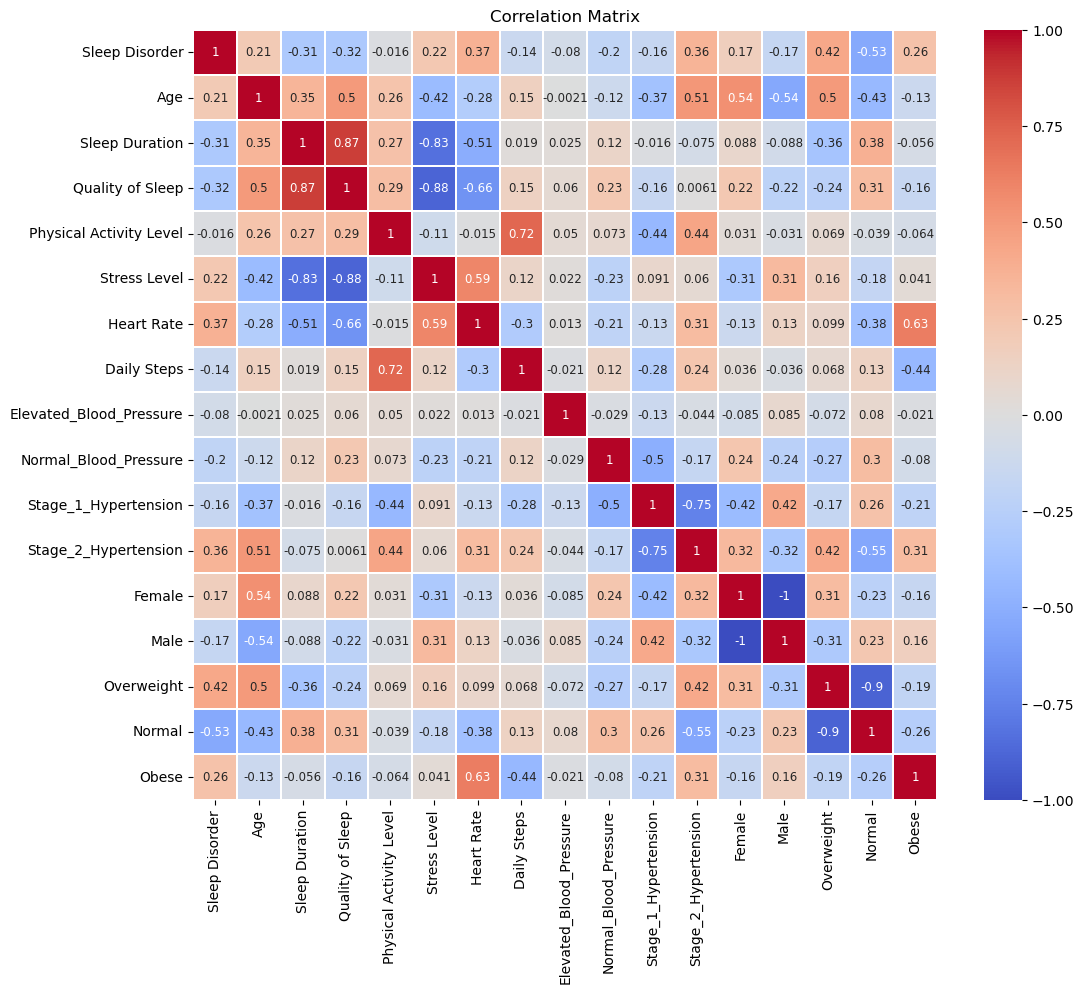

In [44]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.25, annot_kws={"size": 8.5})
plt.title('Correlation Matrix')
plt.show()

In [45]:
disorder_df.columns

Index(['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',
       'Stress Level', 'Heart Rate', 'Daily Steps', 'Sleep Disorder',
       'Elevated_Blood_Pressure', 'Normal_Blood_Pressure',
       'Stage_1_Hypertension', 'Stage_2_Hypertension', 'Female', 'Male',
       'Overweight', 'Normal_Weight', 'Obese', 'Normal'],
      dtype='object')

In [46]:
sdf = correlation_matrix['Sleep Disorder'].sort_values(ascending=False)
sdf

Sleep Disorder             1.000000
Overweight                 0.422614
Heart Rate                 0.374475
Stage_2_Hypertension       0.355363
Obese                      0.261698
Stress Level               0.221275
Age                        0.206158
Female                     0.167183
Physical Activity Level   -0.016382
Elevated_Blood_Pressure   -0.080261
Daily Steps               -0.139524
Stage_1_Hypertension      -0.162231
Male                      -0.167183
Normal_Blood_Pressure     -0.200858
Sleep Duration            -0.313894
Quality of Sleep          -0.318499
Normal                    -0.534495
Name: Sleep Disorder, dtype: float64

In [47]:
df_sdf = sdf.reset_index()
df_sdf.columns = ['Feature', 'Correlation']

In [48]:
df_sdf

,Feature,Correlation
0,Sleep Disorder,1.000000
1,Overweight,0.422614
2,Heart Rate,0.374475
3,Stage_2_Hypertension,0.355363
4,Obese,0.261698
5,Stress Level,0.221275
6,Age,0.206158
7,Female,0.167183
8,Physical Activity Level,-0.016382
9,Elevated_Blood_Pressure,-0.080261


### We can visualize the correlation between sleep disorders and other factors using a bar chart

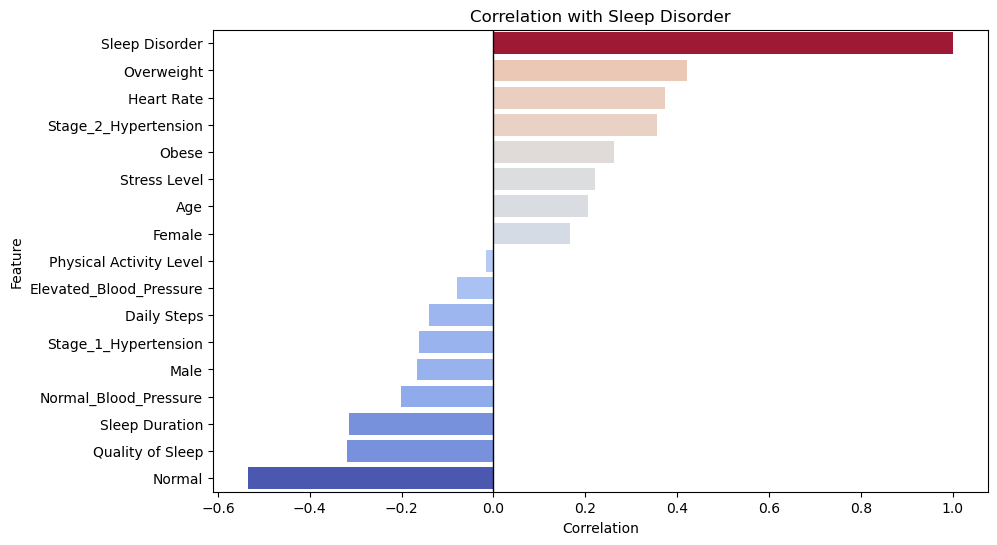

In [49]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Correlation', y='Feature', data=df_sdf, palette='coolwarm', hue='Correlation', legend=False)
plt.title('Correlation with Sleep Disorder')
plt.axvline(0, color='black', linewidth=1)
plt.show()

In [50]:
X = disorder_df.drop(columns=['Sleep Disorder'])  # Features
y = disorder_df['Sleep Disorder']  # Target

### Given that the dataset is small, we use stratified K-fold cross-validation and grid search to ensure that our model generalizes well.

In [104]:
# Define parameters to try
param_grid = {
    'model__C': [0.01, 0.1, 1, 10, 100],
    'model__solver': ['liblinear', 'lbfgs', 'saga'],
    'model__penalty': ['l2'],
    'model__max_iter': [760, 1000]
}

pipeline = Pipeline([('scaler',StandardScaler()),('model',LogisticRegression(random_state=42))])

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=skf, scoring='accuracy')
grid_search.fit(X, y)
# Print the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

Best parameters: {'model__C': 0.01, 'model__max_iter': 760, 'model__penalty': 'l2', 'model__solver': 'liblinear'}
Best cross-validation accuracy: 0.8076923076923077


## Conclusion:
### Our model predicts the test data with a 80.77% accuracy after performing stratified K-fold cross-validation.